<a href="https://colab.research.google.com/github/YamenHabib/tweets_hate_speech_detection/blob/main/Tweets_Hate_Speech_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

install some libs on colab

In [ ]:
try:
    from google.colab import drive
    COLAB = True
    print("using Google CoLab")
except:
    print("not using Google CoLab")
    COLAB = False

using Google CoLab


In [ ]:
if COLAB:
  !pip install datasets
  # !pip install transformers==3
  !pip install -U torchtext==0.8.0
  !pip install protobuf
  !pip install git+https://github.com/huggingface/transformers

     |████████████████████████████████| 194kB 16.1MB/s 
     |████████████████████████████████| 245kB 43.0MB/s 
     |████████████████████████████████| 112kB 51.8MB/s 
     |████████████████████████████████| 7.0MB 14.7MB/s 
  Found existing installation: torchtext 0.9.1
    Uninstalling torchtext-0.9.1:
      Successfully uninstalled torchtext-0.9.1
  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-22h8x2vd
  Running command git clone -q https://github.com/huggingface/transformers /tmp/pip-req-build-22h8x2vd
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 3.3MB 19.6MB/s 
     |████████████████████████████████| 870kB 46.8MB/s 
  Created wheel for transformers: filename=transformers-4.6.0.dev0-cp37-none-any.whl size=2060545 sha256=5041bb41eb098f512833194e8013fcff3105a444d627310b3c4ef95b9a5e3b36
  Stored in directory: /tmp/pip-ephem-wheel-cache-cg

import our necessary libs

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
import torch
import warnings
import logging
warnings.filterwarnings('ignore')
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from datasets import load_dataset
dataset_dict = load_dataset('tweets_hate_speech_detection', split='train')

Using custom data configuration default


Dataset tweets_hate_speech_detection downloaded and prepared to /root/.cache/huggingface/datasets/tweets_hate_speech_detection/default/0.0.0/c32a982d8b2d6233065d820ac655454174f8aaa8faddc74979cf793486acd3b0. Subsequent calls will reuse this data.


In [ ]:
from transformers import RobertaTokenizer, RobertaModel, AdamW, get_linear_schedule_with_warmup

In [ ]:
from torchtext.data import Field, RawField
from torchtext.data import TabularDataset
from torchtext.data import Iterator, BucketIterator

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device('cpu')

print(device)

cuda:0


In [ ]:
data_path = '/content/drive/MyDrive/data/tweets_hate_speech_detection'
df = pd.DataFrame.from_records(dataset_dict)

In [ ]:
# df = pd.DataFrame.from_records(dataset_dict)

## Ecploring our dataset

Count of label 0 (non hate specch) is: 29720 and for label 1 (hate specch) is: 2242 




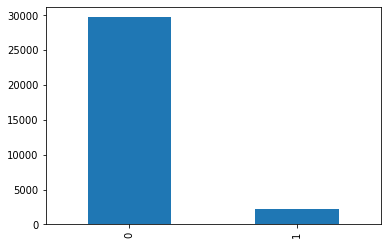

In [ ]:
counts = df['label'].value_counts()
print(f"Count of label 0 (non hate specch) is: {counts[0]} and for label 1 (hate specch) is: {counts[1]}","\n\n")
counts.plot.bar()

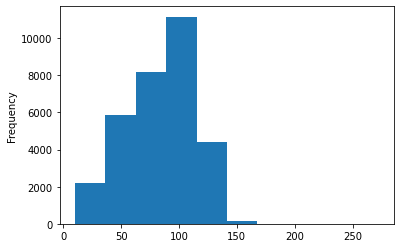

In [ ]:
tweet_length = df['tweet'].str.len().plot.hist()

Text(0.5, 1.0, 'Most Frequently 20 Word')

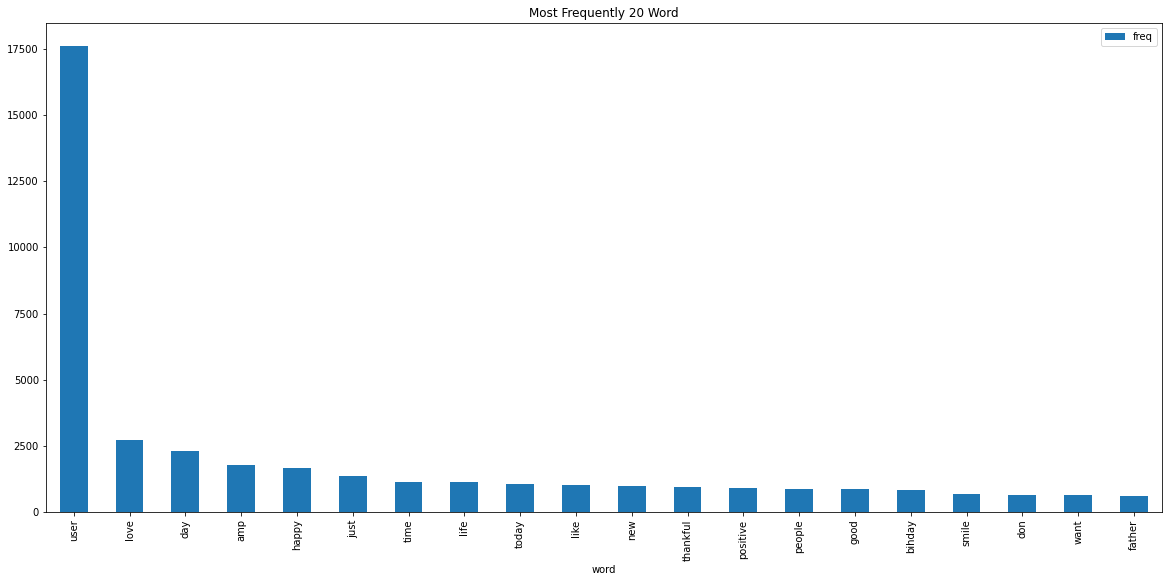

In [ ]:
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(df.tweet)
sum_words = np.squeeze(np.asarray(words.sum(axis=0)))
words_count = [(word, sum_words[i]) for word, i in cv.vocabulary_.items()]
words_count = sorted(words_count, key = lambda x: x[1], reverse = True)
counts = pd.DataFrame(words_count, columns=['word', 'freq'])
counts.head(20).plot(x='word', y='freq', kind='bar', figsize = (20,9))
plt.title("Most Frequently 20 Word")

## Testing zero-shot-classification pipline on the whole dataset

In [ ]:
from transformers import pipeline
classifier = pipeline("zero-shot-classification", model="roberta-base", device=0)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.


In [ ]:
# Save preprocessed data, cropped to max length of the model.
df['tweet'] = df['tweet'].apply(lambda x: " ".join(x.split()[:512]))
df.to_csv(f"{data_path}/prep_tweets.csv")

In [ ]:
path = f"{data_path}/prep_tweets.csv"
label_field = Field(sequential=False,  use_vocab=False, batch_first=True)
# we don't need to make any preprocessing test for the zero-shot pipline.
text_field = RawField()
fields = {'tweet' : ('tweet', text_field),'label' : ('label', label_field)}
#get the dataset from the csv file
dataset = TabularDataset(path= path, format='CSV', fields=fields, skip_header=False)
#define an iterator to walk through the dataset.
dataset_iter = Iterator(dataset, batch_size=1, device=device, train=False, shuffle=False, sort=False)

In [ ]:
# this function will give us the index of max number.
def argmax(iterable):
    return max(enumerate(iterable), key=lambda x: x[1])[0]

In [49]:
argmax([1,2,3,10,3,4])

3

In [ ]:
# define our candidate labels as Hate and not a hate speech
candidate_labels=['Normal', 'Hate']

In [ ]:
results = classifier("You are a wonduful man", candidate_labels)
pred_cls = results['labels'][0]
pred_idx = candidate_labels.index(pred_cls)
candidate_labels[pred_idx]

'Normal'

In [ ]:
results = classifier("You are a hateful black man", candidate_labels)
pred_cls = results['labels'][0]
pred_idx = candidate_labels.index(pred_cls)
candidate_labels[pred_idx]

'Hate'

In [ ]:
def eval_classifier(classifier, candidate_labels, dataset_iter):
  y_pred = []
  y_true = []
  for (tweet,label), _  in dataset_iter:
    source = tweet[0]
    results = classifier(source, candidate_labels)
    pred_cls = results['labels'][0]
    pred_idx = candidate_labels.index(pred_cls)
    y_pred.extend([pred_idx])
    y_true.extend(label.tolist())

  print('Classification Report:')
  print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

  cm = confusion_matrix(y_true, y_pred, labels=[1,0])
  ax = plt.subplot()

  sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")
  ax.set_title('Confusion Matrix')
  ax.set_xlabel('Predicted Labels')
  ax.set_ylabel('True Labels')
  ax.xaxis.set_ticklabels(["Hate", "Normal"])
  ax.yaxis.set_ticklabels(["Hate", "Normal"])
  return y_pred, y_true

Classification Report:
              precision    recall  f1-score   support

           1     0.0387    0.1690    0.0629      2242
           0     0.9159    0.6829    0.7825     29720

    accuracy                         0.6469     31962
   macro avg     0.4773    0.4260    0.4227     31962
weighted avg     0.8544    0.6469    0.7320     31962



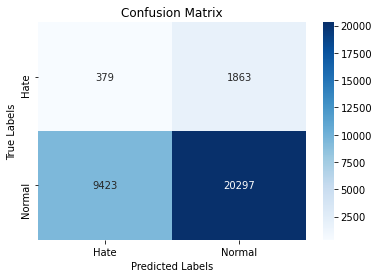

In [ ]:
y_pred, y_true = eval_classifier(classifier, candidate_labels, dataset_iter)

# Building our own model and testing it.

### prepare data pipline

In [ ]:
# Initialize tokenizer.
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [ ]:
# Set tokenizer hyperparameters.
MAX_SEQ_LEN = 256
BATCH_SIZE = 16
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)
path = f"{data_path}/prep_tweets.csv"

# Define columns to read.
label_field = Field(sequential=False,  use_vocab=False, batch_first=True)

text_field = Field(use_vocab=False, tokenize=tokenizer.encode, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)

fields = {'tweet' : ('tweet', text_field),'label' : ('label', label_field)}


In [ ]:
dataset = TabularDataset(path= path, format='CSV', fields=fields, skip_header=False)
train_data, valid_data, test_data = dataset.split(split_ratio=[0.70, 0.2, 0.1],  stratified=True, strata_field='label')

In [ ]:
# Create train and validation iterators.
train_iter, valid_iter = BucketIterator.splits((train_data, valid_data),
                                               batch_size=BATCH_SIZE,
                                               device=device,
                                               shuffle=True,
                                               sort_key=lambda x: len(x.tweet), 
                                               sort=True, 
                                               sort_within_batch=False)

# Test iterator, no shuffling or sorting required.
test_iter = Iterator(test_data, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)

In [ ]:
# print(RobertaModel.from_pretrained('roberta-base'))

### Building our model as roBERTa base model and additional two fully connected layer.

In [ ]:
class ROBERTAClassifier(torch.nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(ROBERTAClassifier, self).__init__()
        
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.d1 = torch.nn.Dropout(dropout_rate)
        self.l1 = torch.nn.Linear(768, 128)
        self.bn1 = torch.nn.LayerNorm(128)
        self.d2 = torch.nn.Dropout(dropout_rate)
        self.l2 = torch.nn.Linear(128, 2)
        torch.nn.init.xavier_uniform(self.l1.weight)
        torch.nn.init.xavier_uniform(self.l2.weight)
        
    def forward(self, input_ids, attention_mask):
        _, x = self.roberta(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        x = self.d1(x)
        x = self.l1(x)
        x = self.bn1(x)
        x = torch.nn.Tanh()(x)
        x = self.d2(x)
        x = self.l2(x)
        
        return x

In [ ]:
output_path = data_path

### Train and Test out model

In [ ]:
def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (source, target), _ in test_loader:
                mask = (source != PAD_INDEX).type(torch.uint8)
                
                output = model(source, attention_mask=mask)

                y_pred.extend(torch.argmax(output, axis=-1).tolist())
                y_true.extend(target.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax = plt.subplot()

    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.xaxis.set_ticklabels(['Hate', 'Normal'])
    ax.yaxis.set_ticklabels(['Hate', 'Normal'])

In [ ]:
#object to hold out our results and to save and reload model and metrics file
class ResultsSaver():
  def __init__(self, train_len, val_len,output_path):
    self.train_losses = []
    self.val_losses = []
    self.steps = []
    
    self.best_val_loss = float('Inf')
    
    self.train_len = train_len
    self.val_len = val_len
    
    self.output_path = output_path
  
  def save_checkpoint(self, path, model, valid_loss):
    torch.save({'model_state_dict': model.state_dict(),'valid_loss': valid_loss}, self.output_path + path)

  def load_checkpoint(self, path, model):    
    state_dict = torch.load(self.output_path + path, map_location=device)
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']

  def save_metrics(self, path):   
    state_dict = {'train_losses': self.train_losses,
                  'val_losses': self.val_losses,
                  'steps': self.steps}
    
    torch.save(state_dict, self.output_path + path)
  
  def load_metrics(self, path):    
    state_dict = torch.load(self.output_path + path, map_location=device)
    return state_dict['train_losses'], state_dict['val_losses'], state_dict['steps']

  def update_train_val_loss(self, model, train_loss, val_loss, step, epoch, num_epochs):

    train_loss = train_loss / self.train_len
    val_loss = val_loss / self.val_len
    self.train_losses.append(train_loss)
    self.val_losses.append(val_loss)
    self.steps.append(step)
    

    print('Epoch [{}/{}], step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}' .format(epoch+1, num_epochs, step, num_epochs * self.train_len, train_loss, val_loss))
    
    # checkpoint
    if self.best_val_loss > val_loss:
        self.best_val_loss = val_loss
        self.save_checkpoint('/model.pkl', model, self.best_val_loss)
        self.save_metrics('/metric.pkl')


In [ ]:
# defin training procedure
def train(model, optimizer, train_iter, valid_iter, results, scheduler = None, num_epochs = 5 , train_whole_model = False):
    step = 0
    # if we want to train all the model (our added layer + roBERTa)
    if train_whole_model:
      for param in model.roberta.parameters():
        param.requires_grad = True
    # in case we just want to train our added layer.
    else:
      for param in model.roberta.parameters():
        param.requires_grad = False
    
    model.train()
    
    for epoch in range(num_epochs):
        train_loss = 0.0                
        val_loss = 0.0
        for (source, target), _ in train_iter:
            mask = (source != PAD_INDEX).type(torch.uint8)
            y_pred = model(input_ids=source, attention_mask=mask)  
            loss = torch.nn.CrossEntropyLoss()(y_pred, target)
            loss.backward()
            # Optimizer and scheduler step
            optimizer.step()    
            scheduler.step()
            optimizer.zero_grad()
            # Update train loss and step
            train_loss += loss.item()
            step += 1

        model.eval()
        with torch.no_grad():                    
            for (source, target), _ in valid_iter:
                mask = (source != PAD_INDEX).type(torch.uint8)
                y_pred = model(input_ids=source,  attention_mask=mask)
                loss = torch.nn.CrossEntropyLoss()(y_pred, target)
                val_loss += loss.item()
        results.update_train_val_loss(model, train_loss, val_loss, step, epoch, num_epochs)       
        model.train()

    results.save_metrics('/metric.pkl')

In [37]:
# Main training loop
NUM_EPOCHS_1 = 6
steps_per_epoch = len(train_iter)
model = ROBERTAClassifier(0.4)
model = model.to(device)
results = ResultsSaver(len(train_iter), len(valid_iter), output_path)


print(" ............. Training the added Layers only ............. ")
optimizer = AdamW(model.parameters(), lr=1e-4)
scheduler = get_linear_schedule_with_warmup(optimizer,  num_warmup_steps=steps_per_epoch*1,  
                                            num_training_steps=steps_per_epoch*NUM_EPOCHS_1)

train(model=model, train_iter=train_iter, valid_iter=valid_iter, optimizer=optimizer, 
      results = results, scheduler=scheduler, num_epochs=NUM_EPOCHS_1, train_whole_model = False)


print(" ............. Training the whole Model ............. ")
NUM_EPOCHS_2 = 6
optimizer = AdamW(model.parameters(), lr=2e-6)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=steps_per_epoch*2, 
                                            num_training_steps=steps_per_epoch*NUM_EPOCHS_2)

train(model=model,  train_iter=train_iter,  valid_iter=valid_iter,  optimizer=optimizer, 
      results = results,  scheduler=scheduler,  num_epochs=NUM_EPOCHS_2, train_whole_model=True)

 ............. Training the added Layers only ............. 
Epoch [1/6], step [1399/8394], Train Loss: 0.4192, Valid Loss: 0.3594
Epoch [2/6], step [2798/8394], Train Loss: 0.2888, Valid Loss: 0.3018
Epoch [3/6], step [4197/8394], Train Loss: 0.2732, Valid Loss: 0.2861
Epoch [4/6], step [5596/8394], Train Loss: 0.2658, Valid Loss: 0.2710
Epoch [5/6], step [6995/8394], Train Loss: 0.2608, Valid Loss: 0.2566
Epoch [6/6], step [8394/8394], Train Loss: 0.2562, Valid Loss: 0.2487
 ............. Training the whole Model ............. 
Epoch [1/6], step [1399/8394], Train Loss: 0.2213, Valid Loss: 0.1389
Epoch [2/6], step [2798/8394], Train Loss: 0.1506, Valid Loss: 0.1177
Epoch [3/6], step [4197/8394], Train Loss: 0.1244, Valid Loss: 0.1108
Epoch [4/6], step [5596/8394], Train Loss: 0.1005, Valid Loss: 0.1050
Epoch [5/6], step [6995/8394], Train Loss: 0.0840, Valid Loss: 0.1026
Epoch [6/6], step [8394/8394], Train Loss: 0.0751, Valid Loss: 0.1036


In [38]:
steps = []
for i, step in enumerate(results.steps):
  if i < NUM_EPOCHS_1:
    steps.append(results.steps[i])
  else:
    steps.append(results.steps[i] + results.steps[NUM_EPOCHS_1-1])

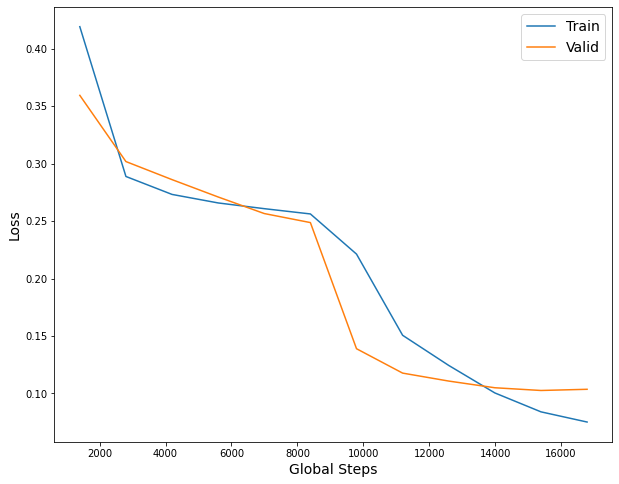

In [39]:
plt.figure(figsize=(10, 8))
#train_loss_list, valid_loss_list, global_steps_list = results.load_metrics(output_path + '/metric.pkl')
plt.plot(steps, results.train_losses , label='Train')
plt.plot(steps, results.val_losses,  label='Valid')
plt.xlabel('Global Steps', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [40]:
model = ROBERTAClassifier()
model = model.to(device)

results.load_checkpoint('/model.pkl', model)

0.10259409242455149

Classification Report:
              precision    recall  f1-score   support

           1     0.8270    0.6830    0.7482       448
           0     0.9764    0.9892    0.9828      5944

    accuracy                         0.9678      6392
   macro avg     0.9017    0.8361    0.8655      6392
weighted avg     0.9659    0.9678    0.9663      6392



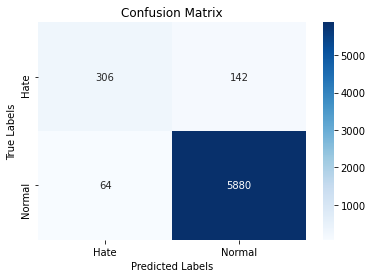

In [41]:
evaluate(model, test_iter)

we can see that our model achieved an accuracy of 0.9678 better than zero-shot-classification pipline which has an acuuracy of 0.6469 

**bold text**# Appendix

#view Words Cloud

Source code: https://github.com/sharmaroshan/Twitter-Sentiment-Analysis/blob/master/Twitter_Sentiment.ipynb

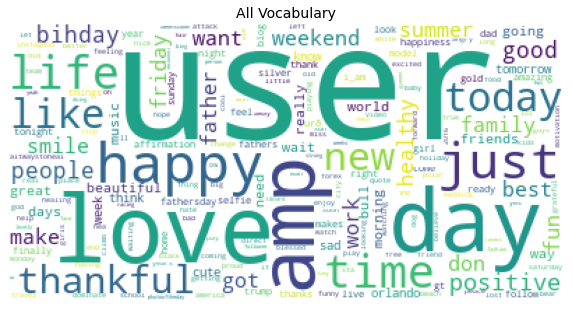

In [42]:
wordcloud = WordCloud(background_color = 'white').generate_from_frequencies(dict(words_count))
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud)
plt.axis('off')
plt.title("All Vocabulary", fontsize = 14)
plt.show()

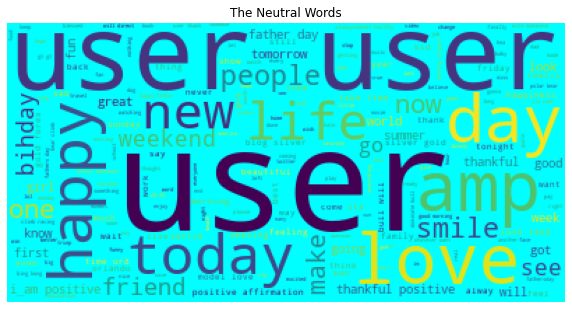

In [43]:
normal_words =' '.join([text for text in df['tweet'][df['label'] == 0]])
wordcloud = WordCloud(background_color = 'cyan').generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('The Neutral Words')
plt.show()

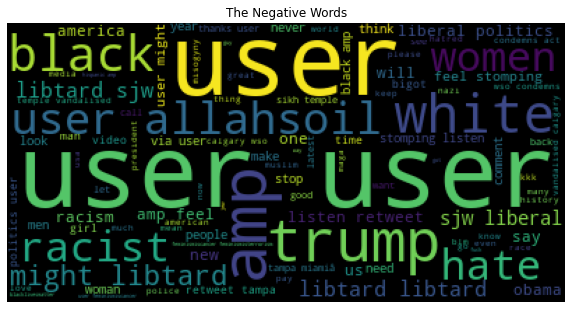

In [44]:
negative_words =' '.join([text for text in df['tweet'][df['label'] == 1]])
wordcloud = WordCloud().generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('The Negative Words')
plt.show()

# Hashtags 

In [45]:
# collecting the hashtags
def hashtag_extract(x):
    hashtags = []
    
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [46]:
# extracting hashtags from non racist/sexist tweets
HT_regular = hashtag_extract(df['tweet'][df['label'] == 0])

# extracting hashtags from racist/sexist tweets
HT_negative = hashtag_extract(df['tweet'][df['label'] == 1])

# unnesting list
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

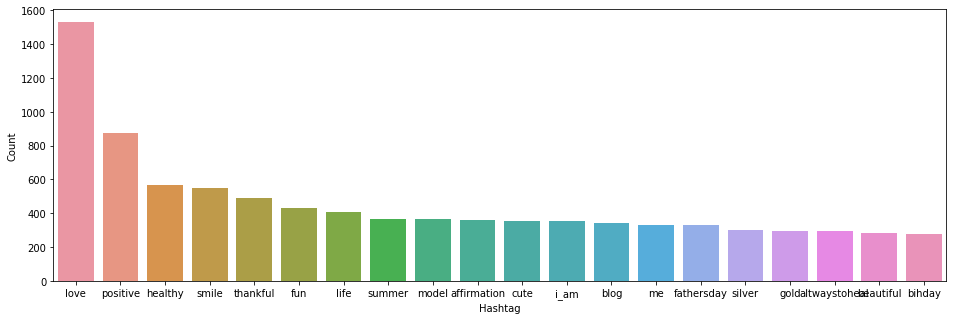

In [47]:
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

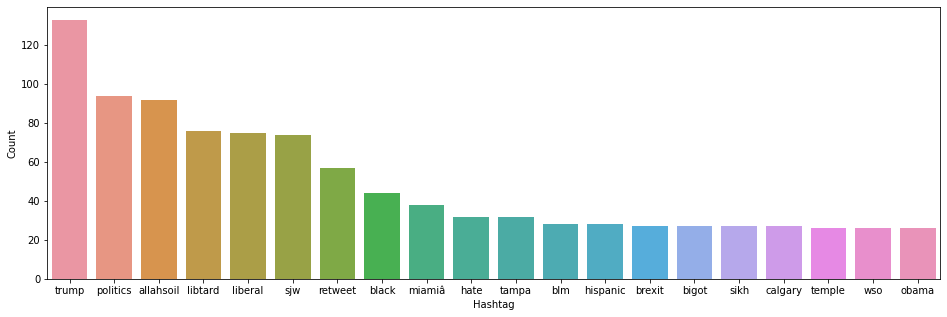

In [48]:
a = nltk.FreqDist(HT_negative)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()